In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import random
import time
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,precision_recall_fscore_support,auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/MaskNomaskdataset/tiny-imagenet-200.zip"
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/tinyimgnet')

In [ ]:
config = dict(
    train_data = "/content/tinyimgnet/tiny-imagenet-200/train",
    test_data = "/content/tinyimgnet/tiny-imagenet-200/val/images",
    test_anno="/content/tinyimgnet/tiny-imagenet-200/val/val_annotations.txt",
    wnids = "/content/tinyimgnet/tiny-imagenet-200/wnids.txt",
    lr = 0.001,
    EPOCHS = 10,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 64,
    pin_memory = True,
    num_workers = 2,
    SEED = 42,
    GPU_ID=0,
    val_split = 0.2
)

In [ ]:
class CustomTestDataset():
  def __init__(self,img_path):
    self.img_path = img_path
    with open(config['wnids']) as f:
      self.wnids = f.read().split('\n')
      self.wnids.remove('')

    with open(config['test_anno']) as f:
      self.test_anno = list(map(lambda x:x.split('\t')[:2],f.read().split("\n")))
      self.test_anno.remove([''])

    self.wnids = sorted(self.wnids,key = lambda x:x)
    self.mapping = dict(list(zip(self.wnids,list(range(200)))))
    # self.rev_mapping = {j:i for i,j in self.mapping.items()}
    self.transformations = transforms.ToTensor()

  def __len__(self):
    return len(self.test_anno)

  def __getitem__(self,idx):
    test_img, class_name = self.test_anno[idx]
    cls_idx = self.mapping.get(class_name,-1)
    
    img = Image.open(os.path.join(config['test_data'],test_img)).convert('RGB')
    img = self.transformations(img)
    return (img,cls_idx)

class CustomTrainDataset():
  def __init__(self,img_path):
    self.img_path = img_path
    with open(config['wnids']) as f:
      self.wnids = f.read().split('\n')
      self.wnids.remove('')
    self.wnids = sorted(self.wnids,key = lambda x:x)
    self.mapping = dict(list(zip(self.wnids,list(range(200)))))

    img_class = os.listdir(self.img_path)
    self.img_map = []
    for clss in img_class:
      cls_imgs = os.listdir(os.path.join(self.img_path,clss,'images'))
      clss_imgs = list(map(lambda x:[clss,x],cls_imgs))
      self.img_map.extend(clss_imgs)
    
    self.transformations = transforms.ToTensor()
  def __len__(self):
    return len(self.img_map)

  def __getitem__(self,idx):
    class_image,image_name = self.img_map[idx]
    cls_idx = self.mapping.get(class_image,-1)

    img = Image.open(os.path.join(self.img_path,class_image,'images',image_name)).convert('RGB')
    img = self.transformations(img)

    return (img,cls_idx)


In [ ]:

device = torch.device(f'cuda:{config["GPU_ID"]}' if torch.cuda.is_available() else 'cpu')
print(device)

config['DEVICE'] = device

torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
  'train':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

cuda:0


In [ ]:
def get_params(model):
  par = 0
  for params in model.parameters():
    if (params.requires_grad == True):
      par += params.numel()
  return par

class Center_loss(nn.Module):
  def __init__(self,embed_dim=256,n_class=200):
    super(Center_loss,self).__init__()
    self.embed_dim = embed_dim
    self.nc = n_class
    self.centers = nn.Parameter(torch.rand(self.nc, self.embed_dim).to(device))

  def forward(self,x,labels):
    # x_shape = [Batch_size, embed_dim]
    assert x.shape[1] == self.embed_dim, "embedding dimensions should be same"
    assert x.shape[0] == labels.shape[0], "no of data in target and x are not same"
    center_labels = torch.tensor([self.centers[i].cpu().detach().numpy() for i in labels])
    center_labels = center_labels.to(device)
    loss = torch.sum(torch.pow((x-center_labels),2)) / (x.shape[0]*x.shape[1])
    return loss


class D_ce(nn.Module):
  def __init__(self,num_class=200):
    super(D_ce,self).__init__()
    self.n_class = num_class
    self.dnet = torchvision.models.resnet18(pretrained=True)
    self.dnet.fc = nn.Linear(512,256)
    self.finalc = nn.Linear(256,self.n_class)
    print(get_params(self.dnet))

    for name,params in self.dnet.named_parameters():
      if (name == "layer4.0.conv1.weight"):
        break
      params.requires_grad = False

    print(get_params(self.dnet))

  def forward(self,x):
    x = self.dnet(x)
    x1 = self.finalc(x)
    return x1,x



In [ ]:
def train(model,train_load,lossfunction1,lossfunction2,optimizer,n_epochs=200):
    tval = {'trainacc':[],"trainloss":[]}
    starttime = time.time()
    for epochs in range(n_epochs):
        model.train()
        cur_loss = 0
        curacc = 0
        len_train = len(train_load)

        avg_loss1 = 0
        avg_loss2 = 0
        for idx , (data,target) in enumerate(train_load):
            data = transformations['train'](data)    
            data = data.to(device)
            target = target.to(device)
            # model = model.to(device)

            scores,emb = model(data)    
            loss1 = lossfunction1(scores,target)
            loss2 = lossfunction2(emb,target)
            # print(loss1,loss2)
            avg_loss1 += (loss1) /(len_train)
            avg_loss2 += (loss2) / (len_train)

            loss = loss1 + loss2
            cur_loss += loss.item() / (len_train)
            scores = F.softmax(scores,dim = 1)
            _,predicted = torch.max(scores,dim = 1)
            correct = (predicted == target).sum()
            samples = scores.shape[0]
            curacc += correct / (samples * len_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print('TrainBatchDone:{:d}'.format(idx),end='\r') 
  
        tval['trainacc'].append(float(curacc))
        tval['trainloss'].append(float(cur_loss))
      
        print('epoch:[{:d}/{:d}], TrainAcc:{:.3f}, TrainLoss:{:.3f}, ce_loss:{:.3f}, cl_loss:{:.3f}'.format(epochs+1,n_epochs,curacc,cur_loss,avg_loss1,avg_loss2)) 

    time2 = time.time() - starttime
    print('done time {:.3f} Mins'.format(time2/60))
    return tval

def evaluate(model,loader,name='test'):
  model.eval()
  correct = 0;samples =0
  pre_prob = []
  lab = []
  predicted_labels = []

  with torch.no_grad():
      for idx,(x,y) in enumerate(loader):
          x = transformations['test'](x)
          x = x.to(device)
          y = y.to(device)
          # model = model.to(device)

          scores,_ = model(x)
          predict_prob = F.softmax(scores)
          _,predictions = predict_prob.max(1)

          predictions = predictions.to('cpu')
          y = y.to('cpu')
          predict_prob = predict_prob.to('cpu')

          predicted_labels.extend(list(predictions.numpy()))
          pre_prob.extend(list(predict_prob.numpy()))
          lab.extend(list(y.numpy()))

          correct += (predictions == y).sum()
          samples += predictions.size(0)

          print('batches done : ',idx,end='\r')
      
      print(f'correct are {correct/samples:.3f}')
      
  model.train()
  return np.array(lab),np.array(predicted_labels),np.array(pre_prob)

def plot_loss_acc(tval):
  plt.figure(figsize=(5,4))
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainloss'],label='loss')
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainacc'],label='accuracy')
  plt.xlabel('epochs')
  plt.ylabel('loss/accuracy')
  plt.title('loss_accuracy')
  plt.legend()
  plt.savefig('loss_acc_2b.svg',format='svg')
  plt.show()

In [ ]:
ctd = CustomTestDataset(config['test_data'])
test_loader = torch.utils.data.DataLoader(ctd,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
cTd = CustomTrainDataset(config['train_data'])
train_set,_ = torch.utils.data.dataset.random_split(cTd,[50000,50000])
train_loader = torch.utils.data.DataLoader(cTd,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])

print(len(train_loader))
print(len(test_loader))

3125
313


In [ ]:
dnet = D_ce()
dnet = dnet.to(device)
lossfunction1 = nn.CrossEntropyLoss()
lossfunction2 = Center_loss()
optimizer = optim.Adam([
                        {'params':dnet.parameters()},
                        {'params':lossfunction2.parameters(),'lr':0.01}
                      ],lr=config['lr'])
history = train(dnet,train_loader,lossfunction1,lossfunction2,optimizer,n_epochs=config['EPOCHS'])


11307840
8525056
epoch:[1/10], TrainAcc:0.293, TrainLoss:3.427, ce_loss:3.070, cl_loss:0.357
epoch:[2/10], TrainAcc:0.428, TrainLoss:2.580, ce_loss:2.343, cl_loss:0.237
epoch:[3/10], TrainAcc:0.510, TrainLoss:2.154, ce_loss:1.945, cl_loss:0.209
epoch:[4/10], TrainAcc:0.594, TrainLoss:1.758, ce_loss:1.560, cl_loss:0.198
epoch:[5/10], TrainAcc:0.675, TrainLoss:1.390, ce_loss:1.199, cl_loss:0.191
epoch:[6/10], TrainAcc:0.744, TrainLoss:1.095, ce_loss:0.908, cl_loss:0.187
epoch:[7/10], TrainAcc:0.799, TrainLoss:0.881, ce_loss:0.700, cl_loss:0.181
epoch:[8/10], TrainAcc:0.838, TrainLoss:0.727, ce_loss:0.553, cl_loss:0.174
epoch:[9/10], TrainAcc:0.865, TrainLoss:0.620, ce_loss:0.452, cl_loss:0.168
epoch:[10/10], TrainAcc:0.885, TrainLoss:0.547, ce_loss:0.387, cl_loss:0.161
done time 19.072 Mins


In [ ]:
y_true,y_pred,pred_prob = evaluate(dnet,test_loader)

correct are 0.431


In [ ]:
precision,recall,f_score,_ = precision_recall_fscore_support(y_true,y_pred)

In [ ]:
print(f'precision: {np.array(precision).mean():.3f}')
print(f'recall: {np.array(recall).mean():.3f}')
print(f'f_score: {np.array(f_score).mean():.3f}')

precision: 0.454
recall: 0.431
f_score: 0.432


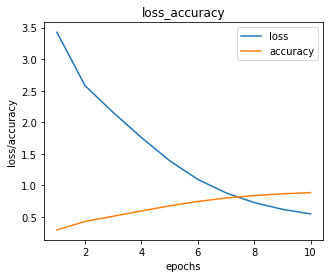

In [ ]:
plot_loss_acc(history)